In [ ]:
import torch

from torchvision.models import vgg16, VGG16_Weights
import torch.nn as nn
from torchvision.transforms import (
    Compose,
    ToTensor,
    Normalize,
    Resize,
    RandomHorizontalFlip,
    RandomVerticalFlip,
)
from torchvision.datasets import ImageFolder

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from classification_model import ClassificationModelBuilding
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import torch.optim as optim
from torchvision.transforms import functional as TF

import os
import fnmatch
import random

from torch.optim.lr_scheduler import ReduceLROnPlateau


In [2]:
# Rotate images at pre-defined angles
class RandomRightRotation:
    def __init__(self, angles=[0, 90, 180, 270]):
        self.angles = angles

    def __call__(self, img):
        angle = random.choice(self.angles)
        return TF.rotate(img, angle)

In [ ]:
train_root_dir = "../data/skin_cancer_train"
val_root_dir = "../data/skin_cancer_val"

device = "cuda" if torch.cuda.is_available() else "cpu"

# Create a dictionary to store the class and its count of samples
class_counts = {}

# Loop through each sub-directory (benign vs malignant)
for class_name in os.listdir(train_root_dir):
    # Create folder path
    class_path = os.path.join(train_root_dir, class_name)
    if os.path.isdir(class_path):
        # Count all images files that are jpg
        num_jpgs = len(fnmatch.filter(os.listdir(class_path), "*.jpg"))
        class_counts[class_name] = num_jpgs

label_to_idx = {"benign": 0, "malignant": 1}
class_weight = {label_to_idx[label]: 1 / count for label, count in class_counts.items()}
class_weight

# Sum both benign and malignant class samples
# total_test_samples = sum(class_counts.values())
# Compute pos_weight
# malignant_weight = class_counts["benign"] / class_counts["malignant"]
# pos_weight = torch.tensor(malignant_weight, dtype=torch.float32).to(device)

{0: 0.0001030290541932825, 1: 0.003401360544217687}

In [4]:
# Transformation for positive class including data augmentation
pos_data_transform = Compose(
    [
        Resize(224),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        RandomHorizontalFlip(p=0.5),
        RandomVerticalFlip(p=0.5),
        RandomRightRotation(angles=[90, 180, 270]),
    ]
)

# Transformation for negative class w/o data augmentation
base_transform = Compose(
    [Resize(224), ToTensor(), Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
)

# Get train dataset
raw_train = ImageFolder(root=train_root_dir, transform=None)

In [5]:
# Apply conditional data augmentation only to positive samples
class ConditionalAugDataset(Dataset):
    def __init__(self, base_dataset, pos_transform, base_transform):
        self.dataset = base_dataset
        self.pos_transform = pos_transform
        self.base_transform = base_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]

        if label == 1:
            img = self.pos_transform(img)
        else:
            img = self.base_transform(img)
        return img, label

In [6]:
gen = torch.Generator()
gen.manual_seed(42)

sample_weight = [class_weight[lb] for lb in raw_train.targets]

sampler = WeightedRandomSampler(
    sample_weight, num_samples=len(sample_weight), replacement=True, generator=gen
)

In [7]:
# Load train and validation datasets and dataloaders
train_dataset = ConditionalAugDataset(raw_train, pos_data_transform, base_transform)
val_dataset = ImageFolder(root=val_root_dir, transform=base_transform)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32)

In [8]:
# Download VGG16 pre-trained model using default weights that will be fine tuned during training
model = vgg16(weights=VGG16_Weights.DEFAULT)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
# Replace the final output layer
model.classifier[6] = nn.Linear(in_features=4096, out_features=1)

In [10]:
torch.manual_seed(13)
loss_fn = nn.BCEWithLogitsLoss()
# loss_fn = FocalLoss(alpha=0.75, gamma=2)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, "min", factor=0.1, patience=3)

# built_model = ClassificationModelBuilding(
#     model, loss_fn, optimizer, train_loader, val_loader
# )
built_model = ClassificationModelBuilding(
    model, loss_fn, optimizer, train_loader, val_loader, scheduler
)
built_model.fit(epochs=20)

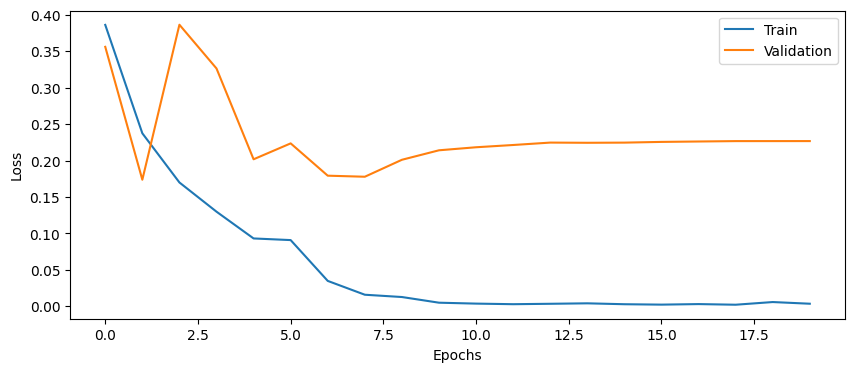

In [11]:
fig = built_model.plot_losses()

In [ ]:
def select_threshold(
    built_model, val_loader, thresholds=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
):

    val_preds = []
    true_labels = []

    for x_batch, y_batch in val_loader:
        preds = built_model.predict(x_batch)
        true_labels.extend(y_batch)
        val_preds.extend(preds)

    val_preds = np.array(val_preds)


    results = []


    for threshold in thresholds:

        pred = (val_preds >= threshold).astype(int)
        acc = accuracy_score(true_labels, pred)
        precision = precision_score(true_labels, pred)
        recall = recall_score(true_labels, pred)
        f1 = f1_score(true_labels, pred)

        results.append(
            {
                "threshold": threshold,
                "accuracy": acc,
                "precision": precision,
                "recall": recall,
                "F1 score": f1,
            }
        )

    df_result = pd.DataFrame(results)

    df_result.sort_values(by="recall", ascending=False)

    return df_result

In [13]:
select_threshold(
    built_model, val_loader, thresholds=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
)

,threshold,accuracy,precision,recall,F1 score
0,0.2,0.967,0.771429,0.900000,0.830769
1,0.3,0.968,0.778846,0.900000,0.835052
2,0.4,0.970,0.794118,0.900000,0.843750
3,0.5,0.970,0.794118,0.900000,0.843750
4,0.6,0.970,0.806122,0.877778,0.840426
5,0.7,0.972,0.829787,0.866667,0.847826
6,0.8,0.973,0.838710,0.866667,0.852459


In [ ]:
test_root_dir = "../data/skin_cancer_test"
test_dataset = ImageFolder(root=test_root_dir, transform=base_transform)
test_loader = DataLoader(test_dataset, batch_size=32)

test_preds = []
test_labels = []
for x_batch, y_batch in test_loader:
    preds = built_model.predict(x_batch)
    test_preds.extend(preds)
    test_labels.extend(y_batch)

test_preds = np.array(test_preds)

pred_labels = (test_preds >= 0.5).astype(int)

acc = accuracy_score(test_labels, pred_labels)
precision = precision_score(test_labels, pred_labels)
recall = recall_score(test_labels, pred_labels)
f1 = f1_score(test_labels, pred_labels)

print(f"Accuracy is {acc:.4f}")
print(f"Precision is {precision:.4f}")
print(f"Recall is {recall:.4f}")
print(f"F1 score is {f1:.4f}")

Accuracy is 0.9670
Precision is 0.7767
Recall is 0.8889
F1 score is 0.8290
